# Bibliotheques

In [1]:
import pandas as pd
from prophet import Prophet
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from catboost import CatBoostRegressor
from datetime import datetime
from pmdarima.arima import auto_arima
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
import dtale


# Chargement des données

In [4]:
df = pd.read_excel("C:\\Users\WINDOWS\\Desktop\\Nouveau dossier\\Nouveau dossier\\ressources_memoire\\P_BB.xlsx")
df

,date,Canal,Region,Sous_famille,ventes
0,2019-01-01,C1,A,P1,80.725952
1,2019-01-01,C1,A,P2,46.322000
2,2019-01-01,C1,A,P3,41.165952
3,2019-01-01,C1,B,P1,36.760256
4,2019-01-01,C1,B,P2,37.618800
...,...,...,...,...,...
1615,2023-12-01,C3,B,P2,167.108800
1616,2023-12-01,C3,B,P3,25.097600
1617,2023-12-01,C3,C,P1,11.124668
1618,2023-12-01,C3,C,P2,222.511200


## Visualisation

In [17]:


# Parcourir les sous-familles
for sous_famille in df['Sous_famille'].unique():
    # Sélectionner les données de la sous-famille en cours
    ventes_sous_famille = df[df['Sous_famille'] == sous_famille]

    # Créer une nouvelle figure avec Plotly
    fig = go.Figure()

    # Parcourir les régions et les canaux pour ajouter des traces
    for region in ventes_sous_famille['Region'].unique():
        ventes_region = ventes_sous_famille[ventes_sous_famille['Region'] == region]
        for canal in ventes_region['Canal'].unique():
            ventes_canaux = ventes_region[ventes_region['Canal'] == canal]
            fig.add_trace(go.Scatter(
                x=ventes_canaux['date'], 
                y=ventes_canaux['ventes'], 
                mode='lines', 
                name=f'{region} - {canal}',
                visible=True  # Initial state
            ))

    # Créer des boutons pour la liste déroulante
    buttons = []
    for trace in fig.data:
        button = dict(
            method='update',
            label=trace.name,
            args=[{'visible': [t == trace for t in fig.data]},
                  {'title': f'Ventes de {sous_famille} - {trace.name}'}]
        )
        buttons.append(button)

    # Ajouter les boutons à la mise en page
    fig.update_layout(
        updatemenus=[dict(
            active=0,
            buttons=buttons,
            x=1.15,
            xanchor='left',
            y=1.15,
            yanchor='top'
        )]
    )

    # Ajouter une légende, un titre et des étiquettes d'axes
    fig.update_layout(
        title=f'Ventes de {sous_famille}',
        xaxis_title='Date',
        yaxis_title='Ventes',
        xaxis=dict(tickangle=45),
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=0.75),
        margin=dict(l=0, r=0, t=50, b=0),
    )

    # Afficher la figure
    fig.show()


# AED

In [18]:
stats_desc = df.describe()
# Affichage des statistiques descriptives du dataset
print(stats_desc)

                      date       ventes
count                 1620  1620.000000
mean   2021-06-16 06:24:00   117.277931
min    2019-01-01 00:00:00     0.516672
25%    2020-03-24 06:00:00    33.364725
50%    2021-06-16 00:00:00    83.062031
75%    2022-09-08 12:00:00   161.101062
max    2023-12-01 00:00:00  1391.468691
std                    NaN   125.652791


## Missing values

In [19]:
# Vérification des valeurs manquantes dans le dataset
missing_values = df.isnull().sum()

# Affichage des valeurs manquantes
print(missing_values)

# Vérification si toutes les valeurs manquantes sont à zéro
if missing_values.sum() == 0:
    print("Les données sont propres")
else:
    print("Il y a des valeurs manquantes dans les données")


date            0
Canal           0
Region          0
Sous_famille    0
ventes          0
dtype: int64
Les données sont propres


## date to datetime

In [4]:
df['date']=pd.to_datetime(df['date'])

# visualisation 


## Par Canal

In [21]:


# Grouper les données par 'Canal' et 'Sous_famille' et sommer les ventes
sales_by_canal_sous_famille = df.groupby(['Canal', 'Sous_famille'])['ventes'].sum().reset_index()

# Obtenir les canaux uniques
canals = df['Canal'].unique()

# Définir une séquence de couleurs personnalisée
couleurs_personnalisees = ['#BDB498', '#0E2C54', '#CAE8FF']

# Créer les sous-graphiques pour chaque canal
fig = make_subplots(rows=1, cols=len(canals), subplot_titles=[f'Canal {canal}' for canal in canals], specs=[[{'type':'pie'}] * len(canals)])

for i, canal in enumerate(canals):
    # Filtrer les données pour le canal spécifique
    data = sales_by_canal_sous_famille[sales_by_canal_sous_famille['Canal'] == canal]
    
    # Ajouter un diagramme circulaire au sous-graphe
    fig.add_trace(go.Pie(
        labels=data['Sous_famille'],
        values=data['ventes'],
        name=f'Canal {canal}',
        hole=0.3,
        marker=dict(colors=couleurs_personnalisees)
    ), row=1, col=i+1)

# Mettre à jour la disposition du graphe pour utiliser le thème 'plotly_dark'
fig.update_layout(
    title_text='Distribution des Ventes par Sous-famille et Canal',
    template='plotly_dark'
)

fig.show()


## par region

In [22]:

# Grouper les données par 'Region' et 'Sous_famille' et sommer les ventes
sales_by_region_sous_famille = df.groupby(['Region', 'Sous_famille'])['ventes'].sum().reset_index()

# Obtenir les régions uniques
regions = df['Region'].unique()

# Définir une séquence de couleurs personnalisée
couleurs_personnalisees = ['#BDB498', '#0E2C54', '#CAE8FF']

# Créer les sous-graphiques pour chaque région
fig = make_subplots(rows=1, cols=len(regions), subplot_titles=[f'Region {region}' for region in regions], specs=[[{'type':'pie'}] * len(regions)])

for i, region in enumerate(regions):
    # Filtrer les données pour la région spécifique
    data = sales_by_region_sous_famille[sales_by_region_sous_famille['Region'] == region]
    
    # Ajouter un diagramme circulaire au sous-graphe
    fig.add_trace(go.Pie(
        labels=data['Sous_famille'],
        values=data['ventes'],
        name=f'Region {region}',
        hole=0.3,
        marker=dict(colors=couleurs_personnalisees)
    ), row=1, col=i+1)

# Mettre à jour la disposition du graphe pour utiliser le thème 'plotly_dark'
fig.update_layout(
    title_text='Distribution des Ventes par Sous-famille et Région',
    template='plotly_dark'
)

fig.show()


# ACF PACF

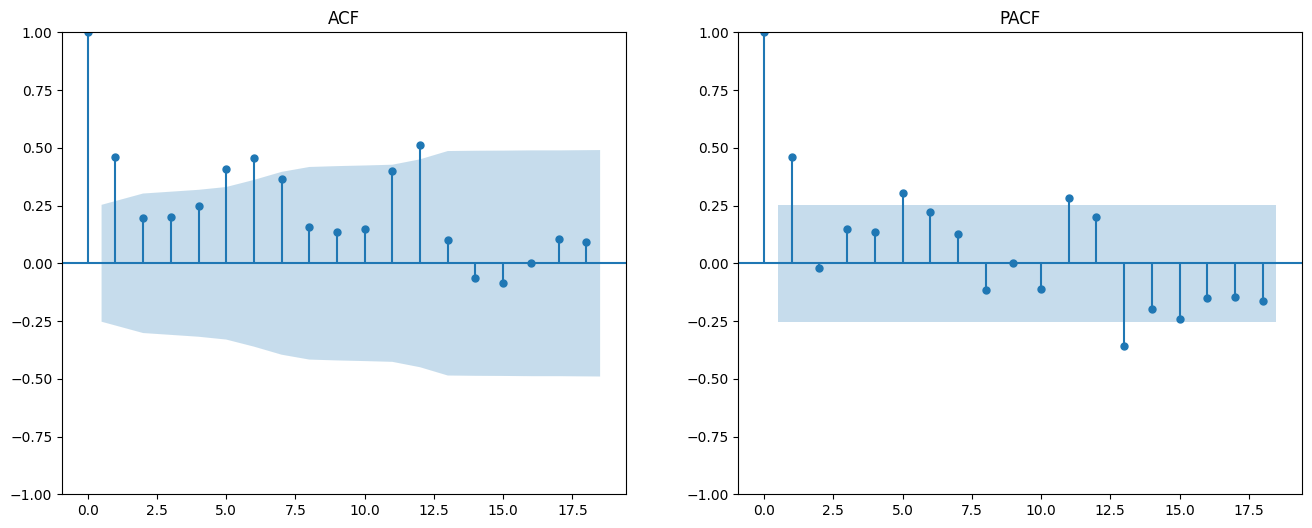

In [5]:
# Filtrer les données pour 'DI Centre Margarine'
filtered_df = df[(df['Canal'] == 'C1') & (df['Region'] == 'A') & (df['Sous_famille'] == 'P1')].copy()

# S'assurer que la colonne de dates est en type datetime
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

# Trier les données par date
filtered_df = filtered_df.sort_values('date')

# Sélectionner la série chronologique (par exemple, les ventes)
sales_series = filtered_df['ventes']

# Tracer l'ACF et la PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF
plot_acf(sales_series, ax=axes[0])
axes[0].set_title('ACF')

# PACF
plot_pacf(sales_series, ax=axes[1])
axes[1].set_title('PACF')

plt.show()

# Sarima

In [5]:
# Filtrer les données pour 'DD Centre Margarine'
filtered_df = df[(df['Canal'] == 'C2') & (df['Region'] == 'A') & (df['Sous_famille'] == 'P1')]

# Convertir la colonne 'date' en index de type datetime
filtered_df.set_index('date', inplace=True)



In [6]:
# Vérifier les données manquantes
print(filtered_df.isnull().sum())

# Remplir les données manquantes si nécessaire
filtered_df.fillna(method='ffill', inplace=True)

Canal           0
Region          0
Sous_famille    0
ventes          0
dtype: int64


In [7]:
# Sélectionner uniquement la colonne 'ventes'
ventes = filtered_df[['ventes']]


In [8]:
# Transformation logarithmique pour stabiliser la variance
ventes['log_ventes'] = np.log1p(ventes['ventes'])


In [11]:
# Définir les dates de début et de fin pour l'ensemble d'entraînement et l'ensemble de test
start_train_date = '2019-01-01'
end_train_date = '2022-10-01'
start_test_date = '2023-11-01'
end_test_date = '2023-12-01'

In [12]:
# Diviser les données en ensembles d'entraînement et de test
train_data = ventes[start_train_date:end_train_date]
test_data = ventes[start_test_date:end_test_date]

In [13]:
# Effectuer le test de Dickey-Fuller pour vérifier la stationnarité
adf_test = adfuller(train_data['log_ventes'])
adf_statistic = adf_test[0]
p_value = adf_test[1]
critical_values = adf_test[4]

In [14]:
print('ADF Statistic: %f' % adf_statistic)
print('p-value: %f' % p_value)
print('Critical Values:')
for key, value in critical_values.items():
    print('\t%s: %.3f' % (key, value))

# Interpréter les résultats du test de Dickey-Fuller
if p_value < 0.05:
    print("La série temporelle est stationnaire (rejette l'hypothèse nulle)")
else:
    print("La série temporelle n'est pas stationnaire (ne rejette pas l'hypothèse nulle)")


ADF Statistic: -0.633685
p-value: 0.863188
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613
La série temporelle n'est pas stationnaire (ne rejette pas l'hypothèse nulle)


In [15]:
# Utiliser auto_arima pour trouver les meilleurs paramètres
model = auto_arima(train_data['log_ventes'], seasonal=True, m=12, trace=True)
# Afficher les paramètres du modèle
print(f'Paramètres du modèle SARIMA : {model.order}')
print(f'Paramètres saisonniers du modèle SARIMA : {model.seasonal_order}')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=18.001, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=21.179, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=21.444, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=19.933, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=19.204, Time=0.11 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=19.449, Time=0.14 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=20.001, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=20.001, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=21.852, Time=0.17 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 3.089 seconds
Paramètres du modèle SARIMA : (0, 0, 0)
Paramètres saisonniers du modèle SARIMA : (0, 1, 0, 12)


In [16]:
# Entraîner le modèle avec les meilleurs paramètres trouvés
mod = SARIMAX(train_data['log_ventes'],
              order=model.order,
              seasonal_order=model.seasonal_order,
              enforce_stationarity=False,
              enforce_invertibility=False)
results = mod.fit()

In [17]:
# Prévoir les ventes sur l'ensemble de test
pred = results.get_prediction(start=pd.to_datetime(start_test_date), end=pd.to_datetime(end_test_date), dynamic=False)
pred_conf = pred.conf_int()

In [18]:
# Convertir les prédictions en échelle originale
predicted_log_ventes = pred.predicted_mean
predicted_ventes = np.expm1(predicted_log_ventes)

In [19]:
# Créer un graphique Plotly
fig = go.Figure()

# Ajouter les valeurs réelles au graphique
fig.add_trace(go.Scatter(x=ventes.index, y=ventes['ventes'], mode='lines', name='Valeurs observées'))

# Ajouter les prévisions au graphique
trace_sar=fig.add_trace(go.Scatter(x=predicted_ventes.index, y=predicted_ventes, mode='lines', name='Prévisions'))

In [20]:
# Afficher le graphique
fig.update_layout(title="Ventes Observées vs Prévisions",
                  xaxis_title="Date",
                  yaxis_title="Ventes",
                  legend=dict(x=0, y=1, traceorder='normal'))
# Mettre en place le thème plotly_dark
fig.update_layout(template="plotly_dark")
fig.show()

# Aligner les index
y_true = test_data['ventes']
y_pred = predicted_ventes

In [21]:
# Calculer les métriques d'évaluation
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(test_data['ventes'], predicted_ventes)


print(f'MAE: {mae}')
# print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R^2: {r_squared}')

MAE: 26.377917999999994
RMSE: 26.523854007895746
R^2: -0.575907288159645


# XGBoost

In [2]:
# Charger les données
df = pd.read_excel("P_BB.xlsx")

# Filtrer les données pour 'DD Centre Margarine'
filtered_df = df[(df['Canal'] == 'C1') & (df['Region'] == 'B') & (df['Sous_famille'] == 'P3')].copy()

In [3]:
# Convertir la colonne 'date' en datetime
filtered_df['date'] = pd.to_datetime(filtered_df['date'])

In [4]:
# Ajouter des caractéristiques de mois et d'année
filtered_df['mois'] = filtered_df['date'].dt.month
filtered_df['annee'] = filtered_df['date'].dt.year

In [5]:
# Appliquer la transformation logarithmique aux ventes
filtered_df['log_ventes'] = np.log1p(filtered_df['ventes'])

In [6]:
# Diviser les données en caractéristiques (X) et cible (y)
X = filtered_df[['mois', 'annee']]
y = filtered_df['log_ventes']


In [7]:
# Filtrer les données pour la période d'entraînement (janvier 2019 à janvier 2023)
train_data = filtered_df[(filtered_df['date'] >= '2019-01-01') & (filtered_df['date'] <= '2022-12-01')]
X_train = train_data[['mois', 'annee']]
y_train = train_data['log_ventes']

# Filtrer les données pour la période de test (après janvier 2023)
test_data = filtered_df[filtered_df['date'] > '2022-12-01']
X_test = test_data[['mois', 'annee']]
y_test = test_data['log_ventes']

In [8]:
# Définir la grille des hyperparamètres à rechercher pour XGBoost
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

In [9]:
# Créer le modèle XGBoost
xgb_model = XGBRegressor()

In [10]:
# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error', n_jobs=-1)

In [11]:
# Exécuter GridSearchCV sur les données d'entraînement
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200, 300],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [12]:
# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres trouvés:")
print(grid_search.best_params_)

Meilleurs paramètres trouvés:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}


In [13]:
# Utiliser les meilleurs paramètres pour entraîner le modèle
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# Faire des prédictions sur l'ensemble de test
log_predictions = best_xgb_model.predict(X_test)

In [17]:
# Inverser la transformation logarithmique pour obtenir les prédictions finales
predictions_xgb = np.expm1(log_predictions)
y_test_original = np.expm1(y_test)

In [18]:
# Visualisation des prédictions et des valeurs observées avec Plotly
trace1 = go.Scatter(x=filtered_df['date'], y=filtered_df['ventes'], mode='lines', name='Valeurs observées')
trace2_XG = go.Scatter(x=test_data['date'], y=predictions_xgb, mode='lines', name='Prédictions')

layout = go.Layout(title='Prévisions vs. Valeurs Observées',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Ventes'))
pio.templates.default = "plotly_dark"
fig = go.Figure(data=[trace1, trace2_XG], layout=layout)
pio.show(fig)

In [19]:
# Calculer les métriques d'évaluation
mse = mean_squared_error(y_test_original, predictions_xgb)
mae = mean_absolute_error(y_test_original, predictions_xgb)
r2 = r2_score(y_test_original, predictions_xgb)
rmse = sqrt(mse)

print("RMSE:", rmse)
print("MAE:", mae)
print("R^2:", r2)

RMSE: 21.494685778295654
MAE: 17.570230683663283
R^2: 0.8847293930568969
